TensorFlow version: 2.9.1
102 classes: ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle'] ...


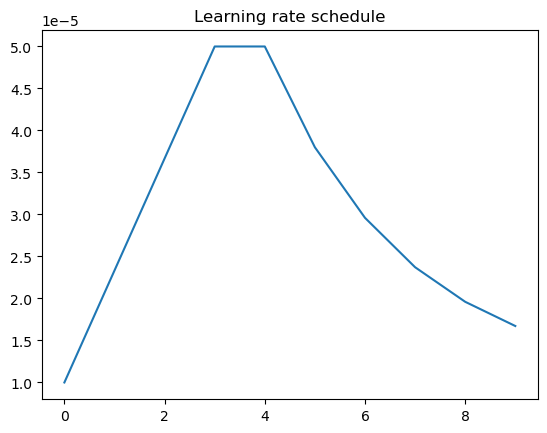

94765736/94765736 [==============================] - 55s 1us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 23,796,710
Trainable params: 208,998
Non-trainable params: 23,587,712
_________________________________________________________________

Epoch 1: LearningRateScheduler settin

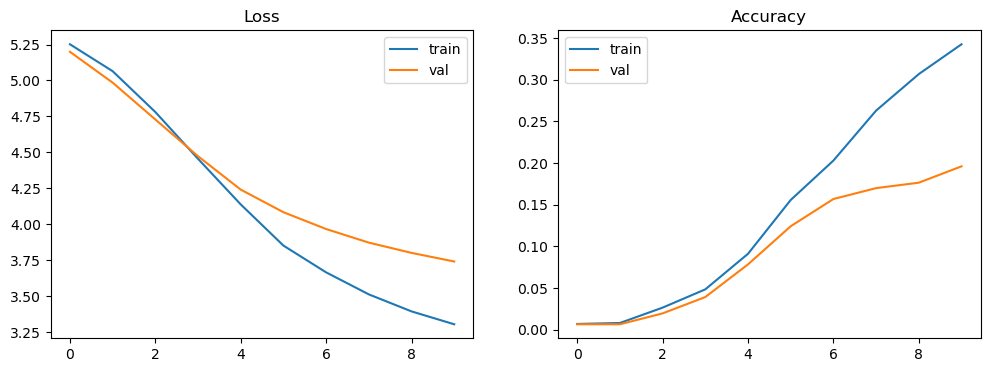

1/1 [==============================] - 0s 293ms/step


C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
C:\Users\Jason Eckert\AppData\Local\Temp\ipykernel_11468\1599125580.py:142: RuntimeWarning: invalid value encountered in divide
  cm_normalized = (cm.T / cm.sum(axis=1)).T


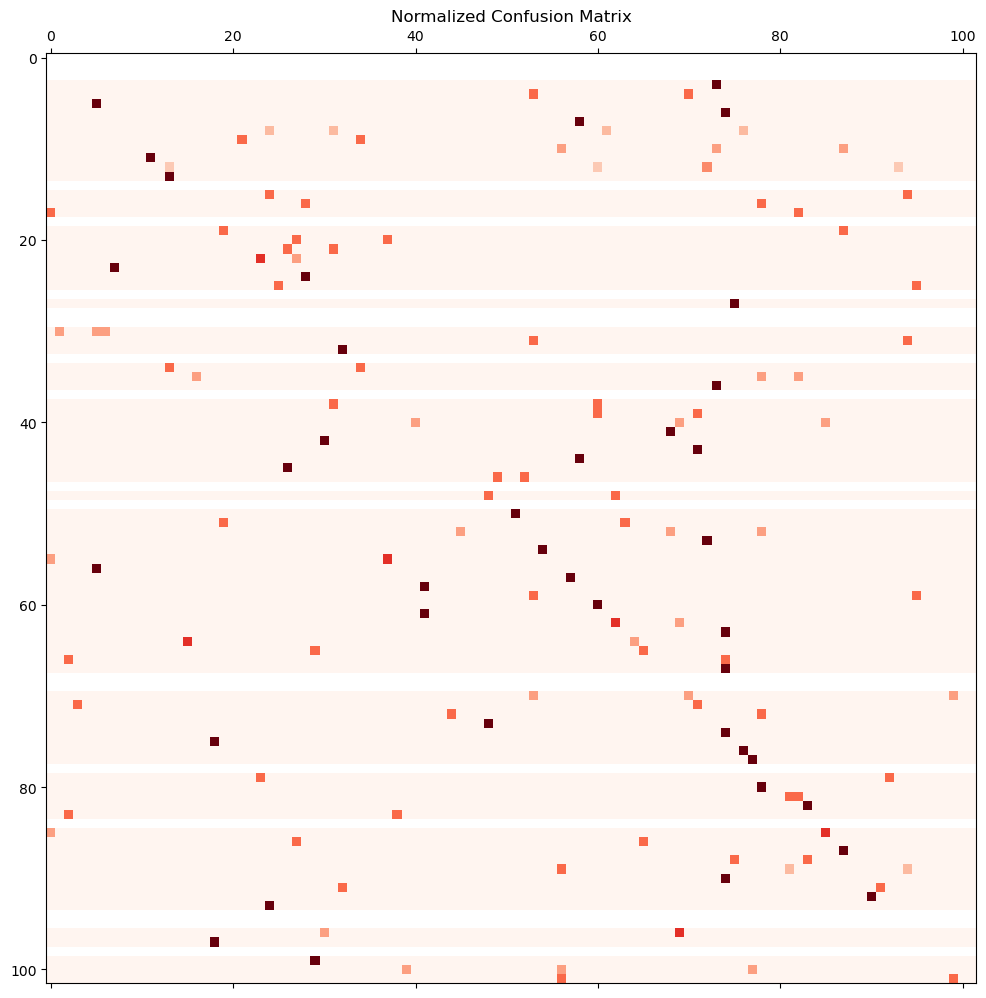

f1: 0.146, precision: 0.150, recall: 0.179


C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\utils\multiclass.py:79: UserWarnin

In [1]:
# Fine-tuning ResNet50 on Flowers102 (via TFDS)
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import math

print("TensorFlow version:", tf.__version__)
AUTO = tf.data.AUTOTUNE

# ------------------------
# Configuration
# ------------------------
IMAGE_SIZE = [224, 224]  # smaller for BYOD-friendly training
BATCH_SIZE = 16          # reduce for CPU/GPU
EPOCHS = 10

# Learning rate schedule
LR_START = 1e-5
LR_MAX = 5e-5
LR_MIN = 1e-5
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 1
LR_EXP_DECAY = 0.7

# ------------------------
# Load TFDS dataset
# ------------------------
(ds_train, ds_val), ds_info = tfds.load(
    "oxford_flowers102",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True,
    with_info=True
)
CLASSES = ds_info.features["label"].names
NUM_CLASSES = ds_info.features["label"].num_classes

print(f"{NUM_CLASSES} classes:", CLASSES[:10], "...")

# ------------------------
# Preprocessing
# ------------------------
def preprocess(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.image.random_flip_left_right(image)
    return image, label

def preprocess_val(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    return image, label

ds_train = ds_train.map(preprocess, num_parallel_calls=AUTO)
ds_train = ds_train.shuffle(1024).batch(BATCH_SIZE).prefetch(AUTO)

ds_val = ds_val.map(preprocess_val, num_parallel_calls=AUTO)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(AUTO)

# ------------------------
# Learning rate scheduler
# ------------------------
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

# Visualize schedule
plt.plot([lrfn(e) for e in range(EPOCHS)])
plt.title("Learning rate schedule")
plt.show()

# ------------------------
# Build model
# ------------------------
pretrained_model = tf.keras.applications.ResNet50(
    weights="imagenet", include_top=False, input_shape=[*IMAGE_SIZE, 3]
)
pretrained_model.trainable = False  # freeze base for initial fine-tuning

model = tf.keras.Sequential([
    tf.keras.layers.Lambda(
        lambda x: tf.keras.applications.resnet.preprocess_input(tf.cast(x, tf.float32)),
        input_shape=[*IMAGE_SIZE, 3]
    ),
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model.summary()

# ------------------------
# Train model
# ------------------------
history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[lr_callback]
)

# ------------------------
# Plot training curves
# ------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['sparse_categorical_accuracy'], label='train')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()
plt.show()

# ------------------------
# Confusion matrix
# ------------------------
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = np.argmax(model.predict(images), axis=-1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
cm_normalized = (cm.T / cm.sum(axis=1)).T

plt.figure(figsize=(12,12))
plt.matshow(cm_normalized, cmap='Reds', fignum=1)
plt.title("Normalized Confusion Matrix")
plt.show()

score = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print(f"f1: {score:.3f}, precision: {precision:.3f}, recall: {recall:.3f}")


# The Following Step 2:
- Unfreezes the last convolutional block of ResNet50 (conv5_x) for fine-tuning.
- Keeps the rest frozen to preserve pre-trained features and avoid overfitting.
- Uses a very low learning rate (1e-5) for stable gradient updates.
- Shows updated training curves and confusion matrix after fine-tuning.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 23,796,710
Trainable params: 15,184,998
Non-trainable params: 8,611,712
_________________________________________________________________

Epoch 11: LearningRateScheduler setting learning rate to 1.470596e-05.
Epoch 11/15
55/55 [===========

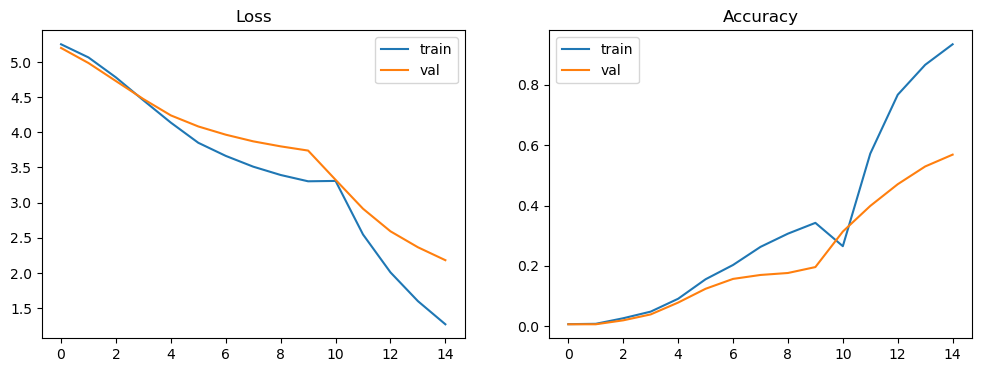

1/1 [==============================] - 0s 294ms/step


C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
C:\Users\Jason Eckert\AppData\Local\Temp\ipykernel_11468\2562408283.py:62: RuntimeWarning: invalid value encountered in divide
  cm_normalized = (cm.T / cm.sum(axis=1)).T


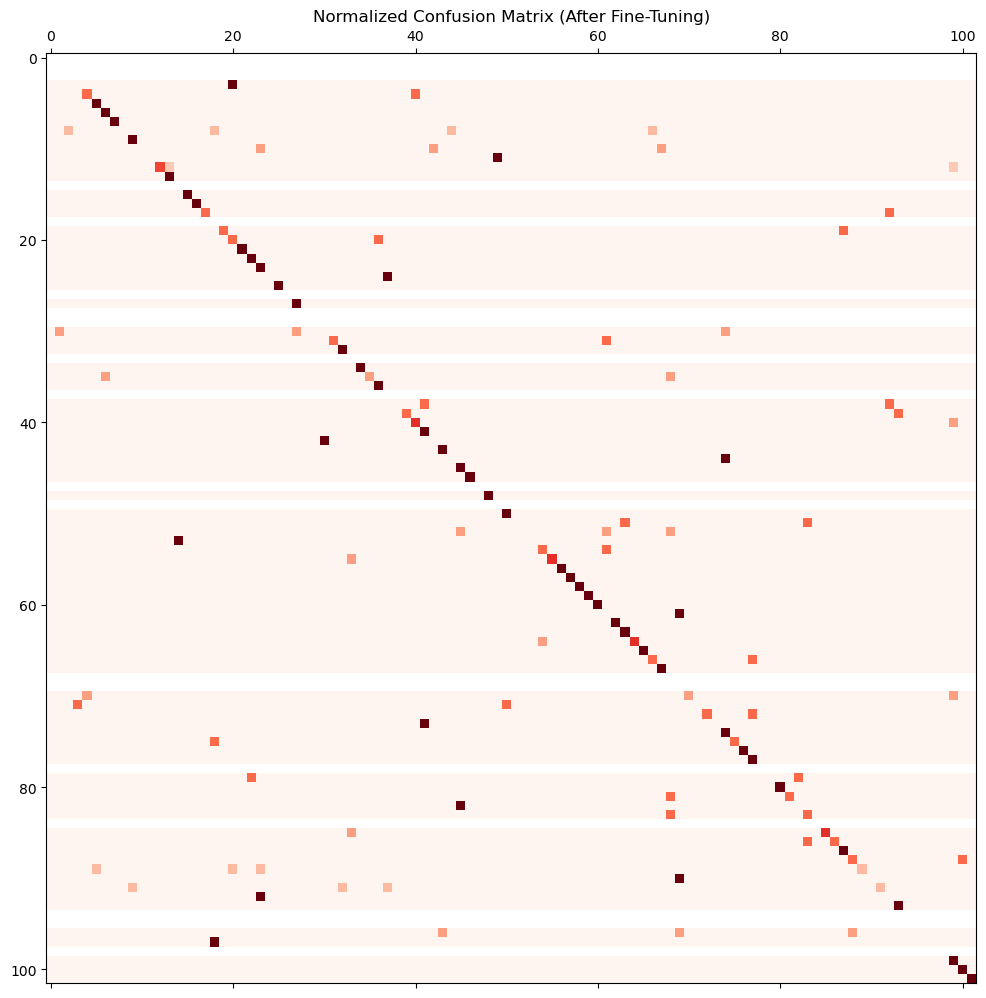

[Fine-tuned] f1: 0.491, precision: 0.516, recall: 0.548


C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
C:\ProgramData\anaconda3\envs\cv\lib\site-packages\sklearn\utils\multiclass.py:79: UserWarnin

In [2]:
# ------------------------
# Step 2: Progressive fine-tuning
# ------------------------

# Unfreeze last few ResNet50 blocks (conv5_block1_out and later)
pretrained_model.trainable = True

# Freeze first layers up to conv4
for layer in pretrained_model.layers[:-33]:  # last 33 layers are conv5_x blocks
    layer.trainable = False

# Compile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

# Fine-tune
fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

history_finetune = model.fit(
    ds_train,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]+1,
    validation_data=ds_val,
    callbacks=[lr_callback]
)

# ------------------------
# Plot updated training curves
# ------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'] + history_finetune.history['loss'], label='train')
plt.plot(history.history['val_loss'] + history_finetune.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['sparse_categorical_accuracy'] + history_finetune.history['sparse_categorical_accuracy'], label='train')
plt.plot(history.history['val_sparse_categorical_accuracy'] + history_finetune.history['val_sparse_categorical_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()
plt.show()

# ------------------------
# Updated confusion matrix after fine-tuning
# ------------------------
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = np.argmax(model.predict(images), axis=-1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
cm_normalized = (cm.T / cm.sum(axis=1)).T

plt.figure(figsize=(12,12))
plt.matshow(cm_normalized, cmap='Reds', fignum=1)
plt.title("Normalized Confusion Matrix (After Fine-Tuning)")
plt.show()

score = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print(f"[Fine-tuned] f1: {score:.3f}, precision: {precision:.3f}, recall: {recall:.3f}")


1/1 [==============================] - 0s 452ms/step


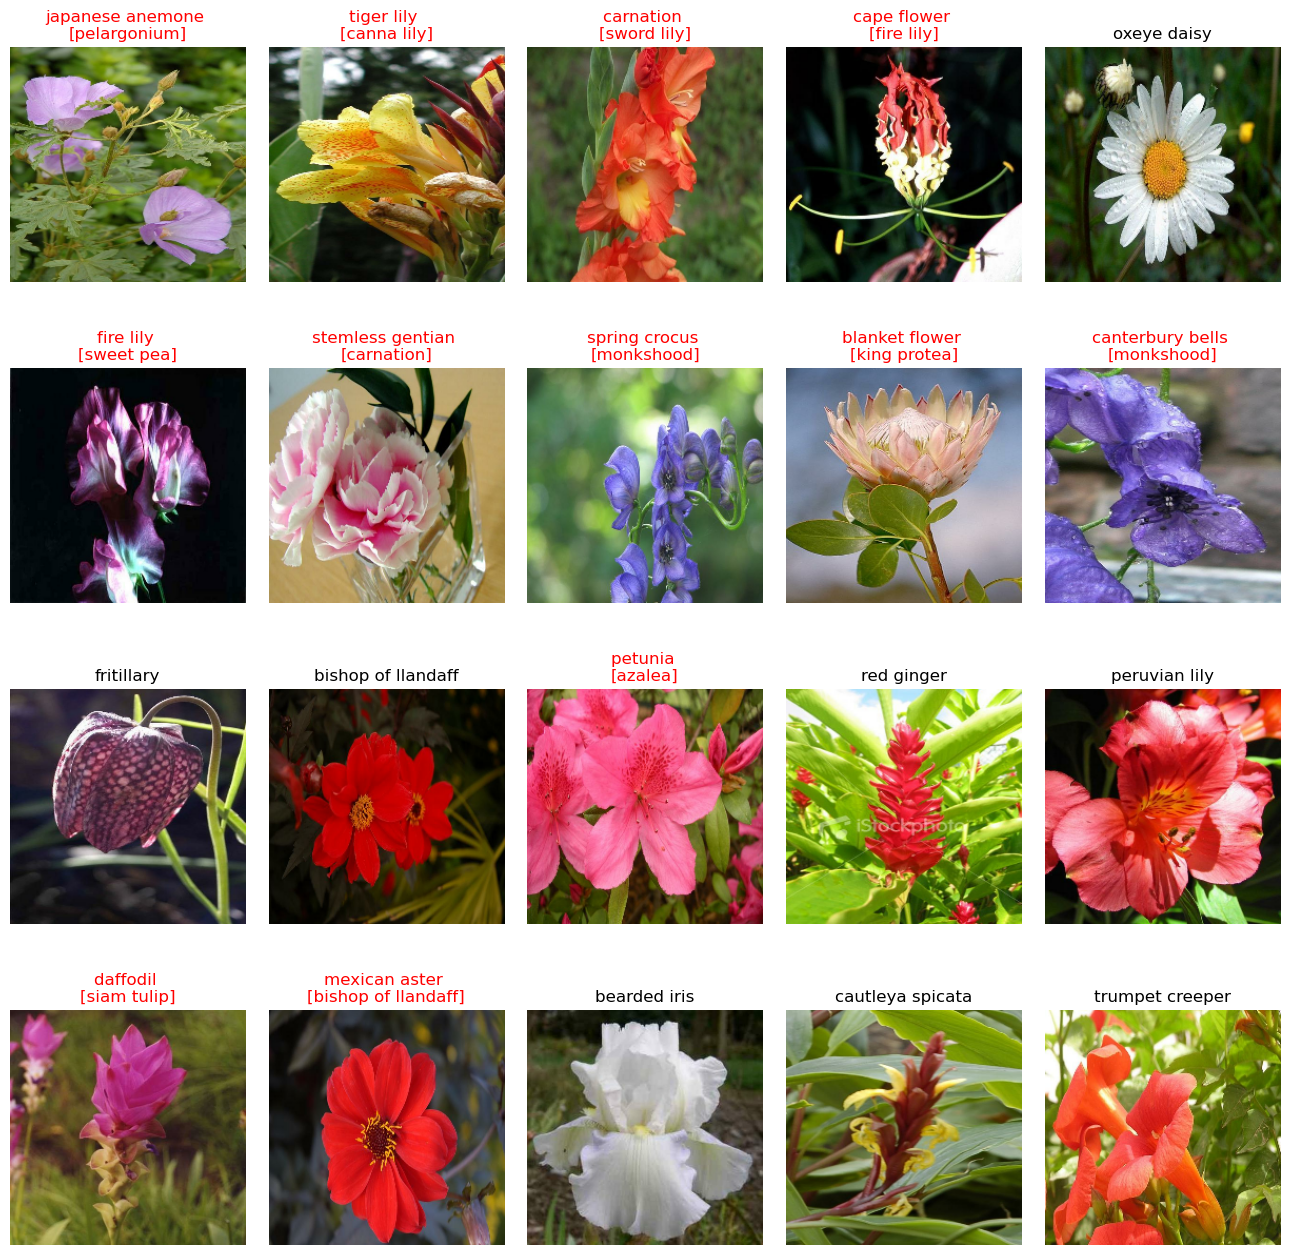

In [3]:
# ------------------------
# Step 3: Display predictions after fine-tuning
# ------------------------

# Create a batch iterator
ds_val_batch = ds_val.unbatch().batch(20)
val_batch_iter = iter(ds_val_batch)
images, labels = next(val_batch_iter)

# Get model predictions
pred_probs = model.predict(images)
pred_labels = np.argmax(pred_probs, axis=-1)

# Display function (reuse your original)
def display_batch_of_images_with_predictions(images, true_labels, pred_labels, classes=CLASSES):
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows, cols, 1)
    plt.figure(figsize=(FIGSIZE, FIGSIZE))
    
    for i, (img, true, pred) in enumerate(zip(images, true_labels, pred_labels)):
        plt.subplot(*subplot)
        plt.axis('off')
        plt.imshow(img.astype("uint8"))
        title_color = 'black' if true == pred else 'red'
        title_text = f"{classes[pred]} \n[{classes[true]}]" if true != pred else f"{classes[pred]}"
        plt.title(title_text, color=title_color, fontsize=12)
        subplot = (rows, cols, subplot[2]+1)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

# Display the batch
display_batch_of_images_with_predictions(images.numpy(), labels.numpy(), pred_labels)
